In [1]:
from torch_geometric import utils

import torch_geometric

In [4]:


import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [5]:
import os
import json
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn    # used for GCN, etc. 
import torch_geometric.utils as pyg_utils # graph utility functions

import time
from datetime import datetime

import networkx as nx  # visualization 
import numpy as np
import torch
import torch.optim as optim
# datasets
from torch_geometric.datasets import TUDataset

from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter # pytorch -> tensorboard
from sklearn.manifold import TSNE   # visualization
import matplotlib.pyplot as plt
from torch_geometric.utils import train_test_split_edges

This notebook is just an exercise to learn more about graph neural net mainly using pytorch geometric and also to start using pytorch lightning. It is highly inspired from https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/GNN_overview.ipynb#scrollTo=_q0qD_QpkF6P but also has a lot from me so take it wtih a grain of salt.

We are going to use a dataset provided by pytorch geometric called ENZYMES which is a collection of enzymes represented as graphs for which each nodes has 21 features related to secondary structure and Amino Acids properties. The features are absolutly not well descibed so I am not going to try any interpretation. Those enzymes are also labeled according to their enzymatic properties, into 6 groups (oxydoreductase, isomerase, transferase, lygase etc...).

My goal was to create an autoencoder where similar graph/enzymes would be close, hoping to see also a cluster in term of enzyme classification. This was just a hope and my latent space is not clustering according to enzyme classification but rather very much by graph topology.

I used a very simple Graph AutoEncoder provided by pytorch geometric with a encoder based on multiple layers made of Graph Isomorphism Network (GIN) https://arxiv.org/pdf/1810.00826.pdf followed by a normalization layer. At the end of those l layers we have a node embedding but to get an actual graph embedding when need to pool the results of all the final node embedding of a single graph together : I tried both mean and max global pooling as the previously mentioned article note that it extracts different types of information.

I didn't norlamize the features : maybe I should but at the same time it should only have an effect on the convergence time not on the final result. I haven't try other GNN layers : maybe I should as this one is really looking to answer the isomorphism question and basically does a WL test -> maybe not the thing to emphasize for our enzyme classification.

In [33]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES',use_node_attr=True)
torch.manual_seed(42)
dataset=dataset.shuffle(42)
train_dataset = dataset[:500]
test_dataset = dataset[500:]

graph_train_loader = DataLoader(train_dataset, batch_size=128,num_workers=4)
graph_val_loader = DataLoader(test_dataset, batch_size=128,num_workers=4) 


Below an example of the graph representation for one specific enzyme

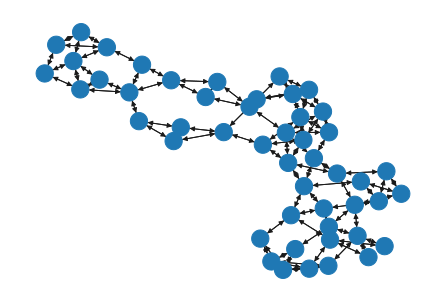

In [155]:
G = utils.to_networkx(dataset[200],to_undirected=False)
nx.draw_kamada_kawai(G)

In [99]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim,n_encode_layer,dropout):
        super(Encoder, self).__init__()
        self.n_encode_layer = n_encode_layer
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.convs.append(pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, n_encode_layer*hidden_dim),
                                  nn.ReLU(), nn.Linear(n_encode_layer*hidden_dim, n_encode_layer*hidden_dim))))
        
        for l in range(n_encode_layer-1,0,-1):
            self.convs.append(pyg_nn.GINConv(nn.Sequential(nn.Linear((l+1)*hidden_dim, l*hidden_dim),
                                  nn.ReLU(), nn.Linear(l*hidden_dim, l*hidden_dim))))
            
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(n_encode_layer*hidden_dim))
        for l in range(n_encode_layer-1,1,-1):
            self.lns.append(nn.LayerNorm(l*hidden_dim))
        
    def forward(self, x, edge_index, batch):
        for i in range(self.n_encode_layer):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.n_encode_layer - 1:
                x = self.lns[i](x)
        #zz=pyg_nn.global_max_pool(x, batch)# here you can choose your pooling :different pooling makes a difference
        zz=pyg_nn.global_mean_pool(x, batch)
        
        list_z=[zz[0]]
        k=0
        for p in range(1,len(batch)):# all of those encoder encodes nodes but the pooling above is at the graph level
            # so here i duplicate the result of the pooling to remake a full graph from it.
            if batch[p]==batch[p-1]:
                list_z.append(zz[k])
            else:
                k+=1
                list_z.append(zz[k])
            
        
        z=torch.vstack(list_z)
        
        
        return x

In [100]:
class GraphLevelGNN(pl.LightningModule):
    
    def __init__(self, input_dim, hidden_dim,n_encode_layer,dropout,lr=5e-5):
        super().__init__()
        self.save_hyperparameters()
        
        self.encoder = Encoder(input_dim, hidden_dim,n_encode_layer,dropout)
        self.model = pyg_nn.GAE(self.encoder)
        self.my_learning_rate=lr
        
        
    
    def forward(self, data, mode="train"):
        
        
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch

        xc = self.model.encode(x, edge_index, batch_idx)
        
        loss = self.model.recon_loss(xc, edge_index)
        
        return loss
        
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.my_learning_rate, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer
        
        
    def training_step(self, batch, batch_idx):
        loss= self.forward(batch, mode="train")
        self.log('train_loss', loss)
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        lo = self.forward(batch, mode="val")
        self.log('val_loss', lo)
        
        
    def test_step(self, batch, batch_idx):
        lo = self.forward(batch, mode="test")
        self.log('test_loss', lo)

Pytorch lightning allows you to rapidly check for a good learning rate :

In [88]:
def train_graph_classifier_tune(model_name,hyper_list):
    pl.seed_everything(42)
    
    
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel_full_duplicate" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         progress_bar_refresh_rate=0,auto_lr_find='my_learning_rate')
    

    
    
    model = GraphLevelGNN(input_dim=hyper_list[0],
                                        hidden_dim=hyper_list[1],n_encode_layer=hyper_list[2],dropout=hyper_list[3])
    
    lr_finder = trainer.tuner.lr_find(model, graph_train_loader, graph_val_loader)
    fig = lr_finder.plot(suggest=True)
    model.hparams.learning_rate = lr_finder.suggestion()

In [89]:
CHECKPOINT_PATH = #your model saving file
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.8 M 
1 | model   | GAE     | 1.8 M 
------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.236     Total estimated model params size (MB)
Global seed set to 42


torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])


/home/seb/anaconda3/envs/geometric_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
Finding best initial lr:   1%|          | 1/100 [00:00<00:13,  7.37it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:   3%|▎         | 3/100 [00:00<00:14,  6.68it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:   4%|▍         | 4/100 [00:00<00:15,  6.34it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 33.345943450927734}
--------------------------------------------------------------------------------


Finding best initial lr:   5%|▌         | 5/100 [00:01<00:45,  2.08it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:   6%|▌         | 6/100 [00:01<00:34,  2.69it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:   8%|▊         | 8/100 [00:02<00:24,  3.76it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 33.265419006347656}
--------------------------------------------------------------------------------


Finding best initial lr:   9%|▉         | 9/100 [00:03<00:47,  1.91it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  11%|█         | 11/100 [00:03<00:28,  3.09it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  12%|█▏        | 12/100 [00:03<00:24,  3.54it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 33.21725082397461}
--------------------------------------------------------------------------------


Finding best initial lr:  13%|█▎        | 13/100 [00:04<00:45,  1.90it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  15%|█▌        | 15/100 [00:05<00:28,  2.97it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  16%|█▌        | 16/100 [00:05<00:24,  3.46it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 33.25010299682617}
--------------------------------------------------------------------------------


Finding best initial lr:  17%|█▋        | 17/100 [00:06<00:42,  1.94it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  19%|█▉        | 19/100 [00:06<00:25,  3.12it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  20%|██        | 20/100 [00:06<00:22,  3.61it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 33.05695343017578}
--------------------------------------------------------------------------------


Finding best initial lr:  21%|██        | 21/100 [00:07<00:40,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  23%|██▎       | 23/100 [00:08<00:24,  3.17it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  24%|██▍       | 24/100 [00:08<00:21,  3.58it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 32.74651336669922}
--------------------------------------------------------------------------------


Finding best initial lr:  25%|██▌       | 25/100 [00:09<00:38,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  27%|██▋       | 27/100 [00:09<00:23,  3.07it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  28%|██▊       | 28/100 [00:09<00:20,  3.55it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 32.04478454589844}
--------------------------------------------------------------------------------


Finding best initial lr:  29%|██▉       | 29/100 [00:10<00:36,  1.97it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  31%|███       | 31/100 [00:11<00:22,  3.03it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  32%|███▏      | 32/100 [00:11<00:19,  3.45it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 29.19024085998535}
--------------------------------------------------------------------------------


Finding best initial lr:  33%|███▎      | 33/100 [00:12<00:34,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  35%|███▌      | 35/100 [00:12<00:21,  3.09it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  36%|███▌      | 36/100 [00:12<00:18,  3.53it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 23.45100212097168}
--------------------------------------------------------------------------------
torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])


Finding best initial lr:  38%|███▊      | 38/100 [00:14<00:26,  2.35it/s]

torch.Size([50])
torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])


Finding best initial lr:  39%|███▉      | 39/100 [00:14<00:20,  2.91it/s]

torch.Size([4320, 50]) torch.Size([4320, 50])
torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])


Finding best initial lr:  40%|████      | 40/100 [00:14<00:18,  3.29it/s]

torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 22.457517623901367}
--------------------------------------------------------------------------------


Finding best initial lr:  41%|████      | 41/100 [00:15<00:31,  1.85it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  43%|████▎     | 43/100 [00:15<00:19,  2.97it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  44%|████▍     | 44/100 [00:16<00:16,  3.49it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 8.963553428649902}
--------------------------------------------------------------------------------


Finding best initial lr:  45%|████▌     | 45/100 [00:17<00:28,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  47%|████▋     | 47/100 [00:17<00:16,  3.13it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  48%|████▊     | 48/100 [00:17<00:14,  3.59it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 7.232177734375}
--------------------------------------------------------------------------------


Finding best initial lr:  49%|████▉     | 49/100 [00:18<00:25,  2.01it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  51%|█████     | 51/100 [00:18<00:16,  3.06it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  52%|█████▏    | 52/100 [00:19<00:13,  3.51it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 4.854788303375244}
--------------------------------------------------------------------------------


Finding best initial lr:  53%|█████▎    | 53/100 [00:20<00:24,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  55%|█████▌    | 55/100 [00:20<00:14,  3.07it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  56%|█████▌    | 56/100 [00:20<00:12,  3.56it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.4377996921539307}
--------------------------------------------------------------------------------


Finding best initial lr:  57%|█████▋    | 57/100 [00:21<00:22,  1.92it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  59%|█████▉    | 59/100 [00:21<00:13,  3.03it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  60%|██████    | 60/100 [00:22<00:11,  3.53it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.5080716609954834}
--------------------------------------------------------------------------------


Finding best initial lr:  61%|██████    | 61/100 [00:23<00:19,  1.95it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  63%|██████▎   | 63/100 [00:23<00:12,  3.06it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  64%|██████▍   | 64/100 [00:23<00:10,  3.56it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.401309847831726}
--------------------------------------------------------------------------------


Finding best initial lr:  65%|██████▌   | 65/100 [00:24<00:17,  1.95it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  66%|██████▌   | 66/100 [00:24<00:13,  2.50it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  68%|██████▊   | 68/100 [00:25<00:09,  3.45it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3856956958770752}
--------------------------------------------------------------------------------


Finding best initial lr:  69%|██████▉   | 69/100 [00:26<00:15,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  71%|███████   | 71/100 [00:26<00:09,  3.13it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  72%|███████▏  | 72/100 [00:26<00:07,  3.54it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3821156024932861}
--------------------------------------------------------------------------------


Finding best initial lr:  73%|███████▎  | 73/100 [00:27<00:13,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  75%|███████▌  | 75/100 [00:28<00:08,  3.11it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  76%|███████▌  | 76/100 [00:28<00:06,  3.57it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3799371719360352}
--------------------------------------------------------------------------------


Finding best initial lr:  77%|███████▋  | 77/100 [00:29<00:11,  1.99it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  79%|███████▉  | 79/100 [00:29<00:06,  3.19it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  80%|████████  | 80/100 [00:29<00:05,  3.69it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.398568868637085}
--------------------------------------------------------------------------------


Finding best initial lr:  81%|████████  | 81/100 [00:30<00:09,  1.97it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  83%|████████▎ | 83/100 [00:31<00:05,  3.10it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  84%|████████▍ | 84/100 [00:31<00:04,  3.54it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.6480945348739624}
--------------------------------------------------------------------------------


Finding best initial lr:  85%|████████▌ | 85/100 [00:32<00:07,  1.97it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  87%|████████▋ | 87/100 [00:32<00:04,  3.10it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  88%|████████▊ | 88/100 [00:32<00:03,  3.56it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3862943649291992}
--------------------------------------------------------------------------------


Finding best initial lr:  89%|████████▉ | 89/100 [00:33<00:05,  1.96it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  90%|█████████ | 90/100 [00:33<00:04,  2.45it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  92%|█████████▏| 92/100 [00:34<00:02,  3.45it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3862943649291992}
--------------------------------------------------------------------------------


Finding best initial lr:  93%|█████████▎| 93/100 [00:35<00:03,  1.93it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  95%|█████████▌| 95/100 [00:35<00:01,  2.93it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr:  96%|█████████▌| 96/100 [00:35<00:01,  3.36it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])
torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 1.3862943649291992}
--------------------------------------------------------------------------------


Finding best initial lr:  97%|█████████▋| 97/100 [00:36<00:01,  1.92it/s]

torch.Size([50])
torch.Size([3848, 50]) torch.Size([3848, 50])
torch.Size([50])


Finding best initial lr:  99%|█████████▉| 99/100 [00:37<00:00,  3.06it/s]

torch.Size([4247, 50]) torch.Size([4247, 50])
torch.Size([50])
torch.Size([4320, 50]) torch.Size([4320, 50])


Finding best initial lr: 100%|██████████| 100/100 [00:37<00:00,  3.52it/s]

torch.Size([50])
torch.Size([3744, 50]) torch.Size([3744, 50])


Restoring states from the checkpoint file at /home/seb/Documents/Work/Bailer/Python/XML-R/exo_pytorch_geometric/saved_models/GraphLevel_full_duplicate_GIN_AE/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/seb/Documents/Work/Bailer/Python/XML-R/exo_pytorch_geometric/saved_models/GraphLevel_full_duplicate_GIN_AE/lr_find_temp_model.ckpt


torch.Size([50])
torch.Size([3421, 50]) torch.Size([3421, 50])
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 34.53877639770508}
--------------------------------------------------------------------------------


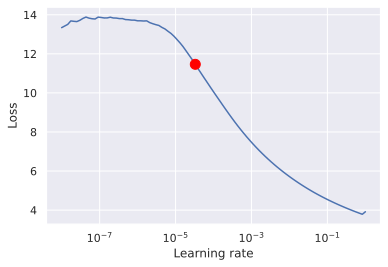

In [90]:
train_graph_classifier_tune("_GIN_AE",[21,50,10,0.5])

With the right learning rate I train my network, and check how training goes using tensorboard.

In [92]:
from pytorch_lightning import loggers as pl_loggers
def train_graph_classifier(model_name,hyper_list):
    pl.seed_everything(42)
    
    
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel_full_duplicate" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=3000,
                         progress_bar_refresh_rate=0)
    

    
    
    model = GraphLevelGNN(input_dim=hyper_list[0],
                                        hidden_dim=hyper_list[1],n_encode_layer=hyper_list[2],dropout=hyper_list[3])
    
    
    trainer.fit(model, graph_train_loader, graph_val_loader)
    
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,input_dim=hyper_list[0],
                                        hidden_dim=hyper_list[1],n_encode_layer=hyper_list[2],dropout=hyper_list[3])
    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=graph_val_loader, verbose=False)
    result = {"test": test_result[0]['test_loss'], "train": train_result[0]['test_loss']} 
    return model, result

In [101]:
model_fitted, result = train_graph_classifier("_GIN_AE_mean",[21,50,10,0.5])


Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.8 M 
1 | model   | GAE     | 1.8 M 
------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.236     Total estimated model params size (MB)
Global seed set to 42
/home/seb/anaconda3/envs/geometric_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/home/seb/anaconda3/envs/geometric_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` 

### Global mean pooling

In [102]:
#encoding in the latent space our graphs thanks to our trained model
#this is for the model trained with gloabl mean pooling
model_fitted.eval()
embedd_mean=[]
target=[]
with torch.no_grad():
    for data in graph_train_loader:
        y=data.y
        batch=data.batch
        edge_index=data.edge_index
        x=data.x
        xx=model_fitted.encoder(x,edge_index,batch)
        list_z=[xx[0]]
        
        for p in range(1,len(batch)):
            if batch[p]!=batch[p-1]:
                list_z.append(xx[p])
        z=torch.vstack(list_z)    
        target+=y.cpu().detach().numpy().tolist()
        embedd_mean+=z.cpu().detach().numpy().tolist()

In [ ]:
t_sne_mean=TSNE()
t_sne_mean_emb=t_sne_mean.fit_transform(embedd_mean)

The latent space draw clear clusters but they don't correspond to enzyme classification (color represent enzyme classification)

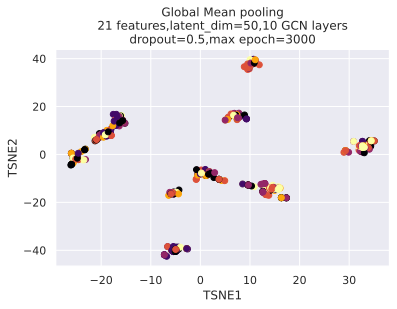

In [141]:
#[21,50,10,0.5] 3000


plt.scatter(t_sne_mean_emb[:,0], t_sne_mean_emb[:,1], c=target,cmap='inferno')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Global Mean pooling\n21 features,latent_dim=50,10 GCN layers\ndropout=0.5,max epoch=3000')
plt.show()

Let's get those cluster out and see what they encompass

In [108]:
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



def getSilhouetteProfile( X , nb_clusters ):
    """
    Takes:
        - X (np.array | pd.DataFrame): data to perform the clustering. Preferably scaled or from a pca
        - nb_clusters (iterable): list containing the different number of clusters to test
    
    Returns:
        (tuple) : (list) : inertia values corresponding to each number of clusters values
                  (list) : silhouette values corresponding to each number of clusters values
                
    """

    inertias = []
    silhouettes = []
    for n in nb_clusters:
        kmeans = cluster.KMeans(n)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X,kmeans.labels_))
    return inertias , silhouettes

best K : 10


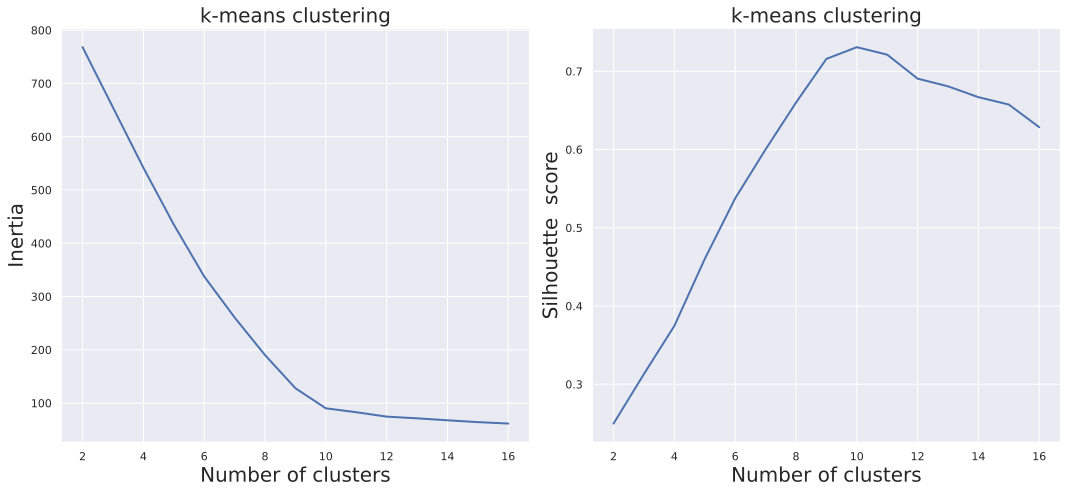

In [110]:
#this pca step is pretty stupid since we work in the latent space representation.. I didn't think that through
pca = PCA()
X_pca_mean = pca.fit_transform(embedd_mean)



nr_clusters = np.arange(15)+2
inertias , silhouettes = getSilhouetteProfile( X_pca_mean , nr_clusters )

## getting the K with maximum silhouette
bestI = np.argmax( silhouettes )
bestK = nr_clusters[bestI]
print('best K :',bestK)

plt.subplots(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(nr_clusters, inertias, ls="-", lw=2)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Inertia',fontsize=20)
plt.title('k-means clustering',fontsize=20)

plt.subplot(1,2,2)
plt.plot(nr_clusters, silhouettes, ls="-", lw=2)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Silhouette  score',fontsize=20)
plt.title('k-means clustering',fontsize=20)

plt.tight_layout()
plt.show()

10 clusters seems to be a good number according to silhouette score.

In [111]:
kmeans_means = cluster.KMeans(10)
kmeans_means.fit(X_pca_mean)

KMeans(n_clusters=10)

In [129]:
knn_mean_label=kmeans_means.labels_
dico_graph_cluster_mean={}
for i,data in enumerate(train_dataset):
    dico_graph_cluster_mean[i]=knn_mean_label[i]

Here a plot 4 graphs from each found clusters : graph from the same cluster looks alike a lot !!! Overall I would say that this first implementation of a grpah auto encoder is a success and I should be able to deploy it to my tweeter project.

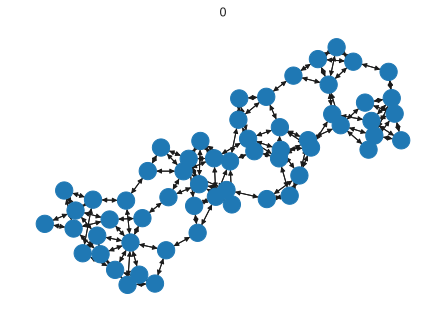

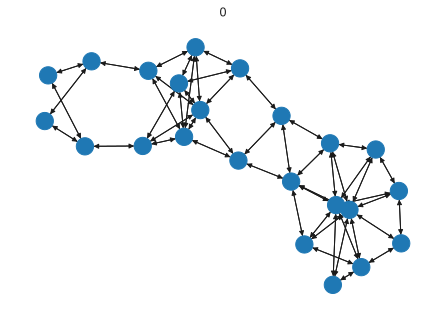

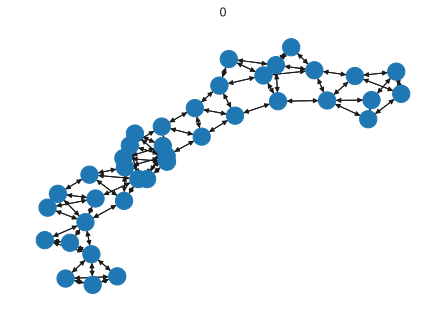

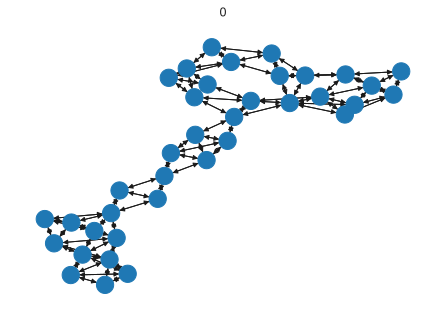

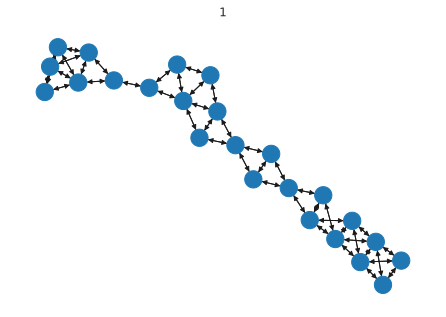

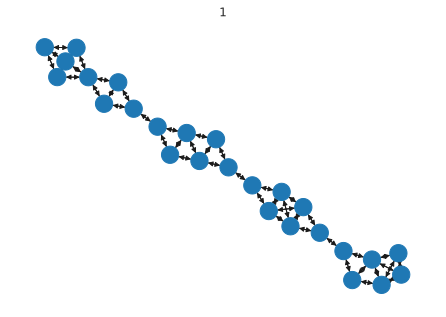

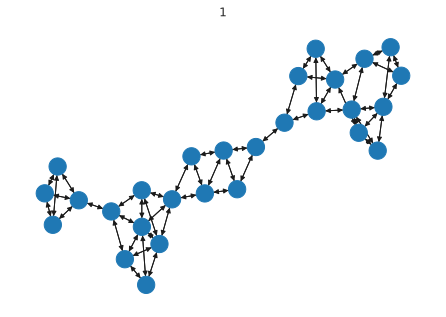

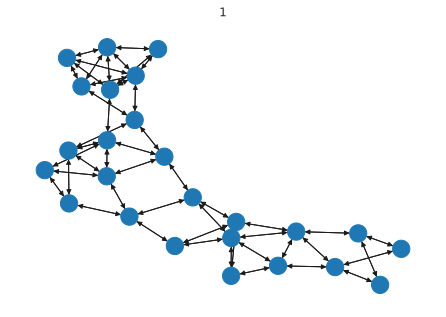

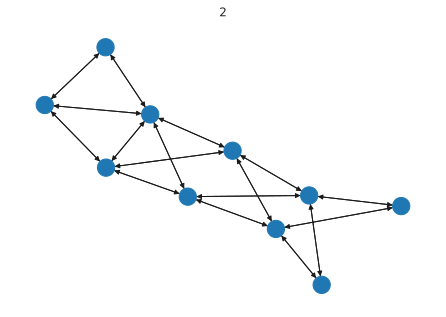

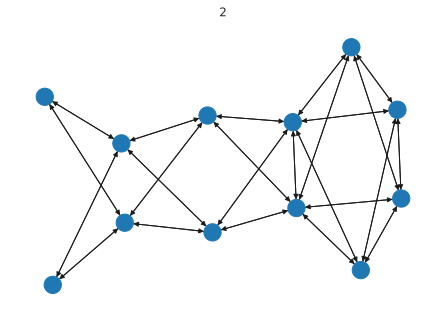

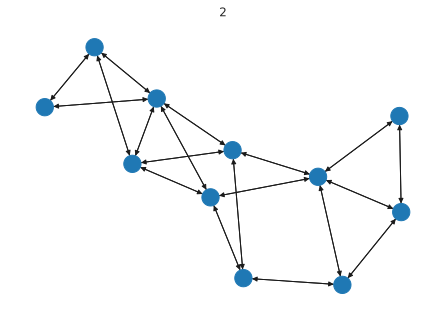

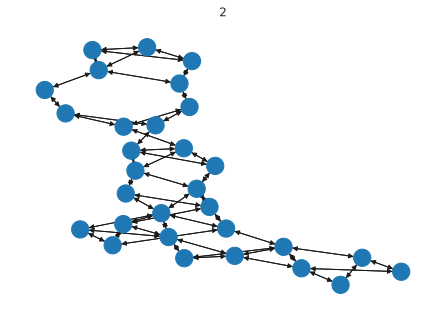

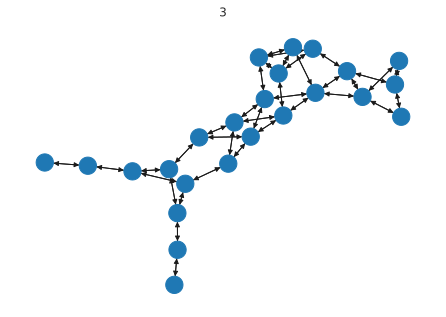

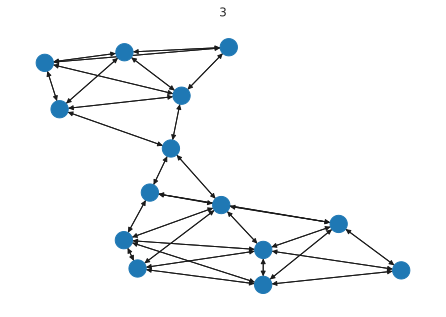

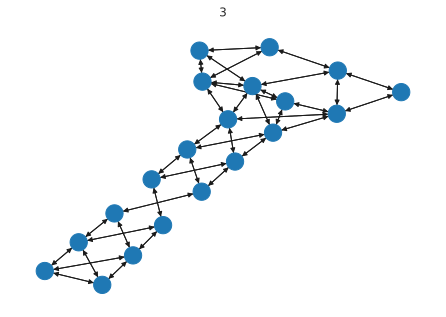

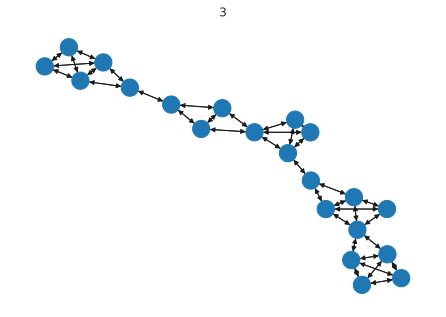

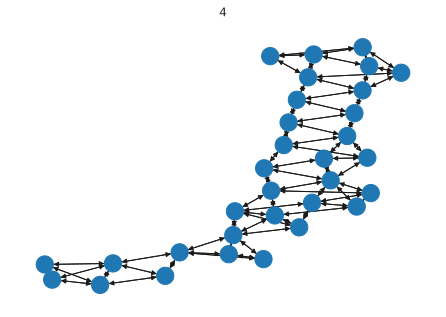

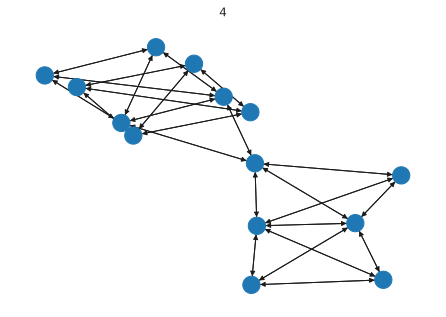

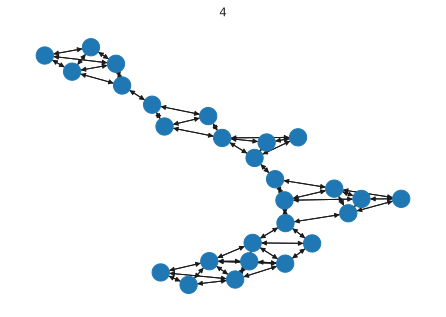

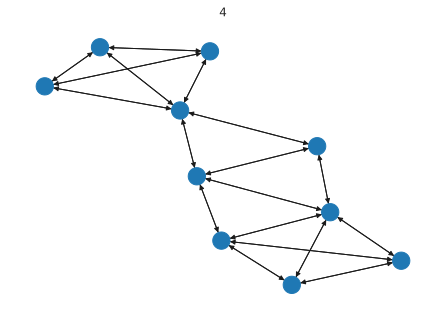

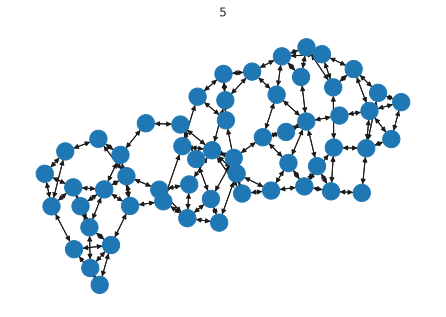

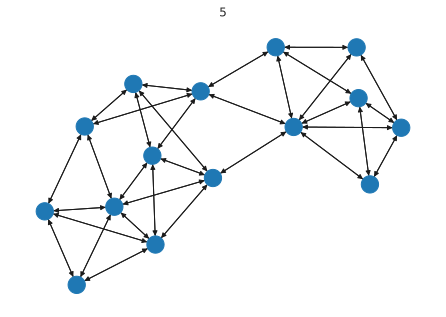

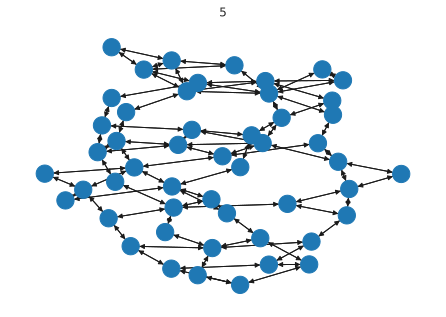

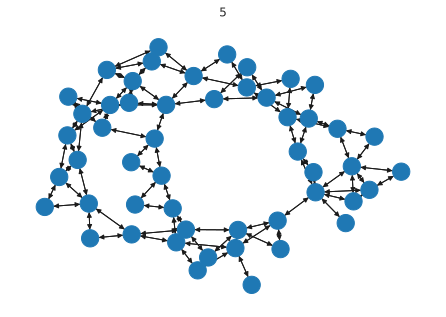

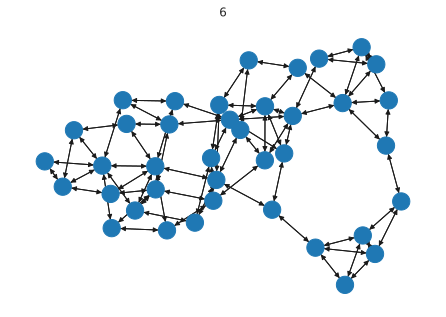

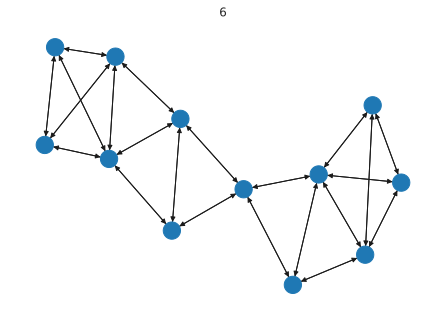

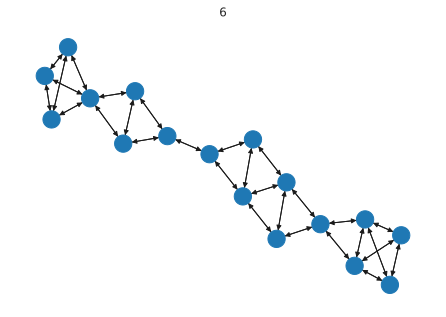

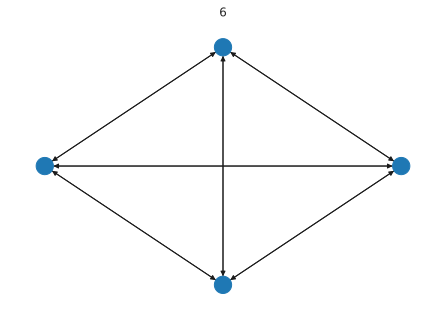

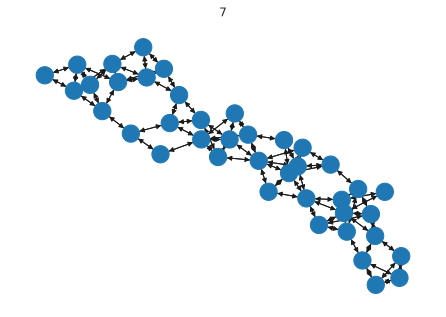

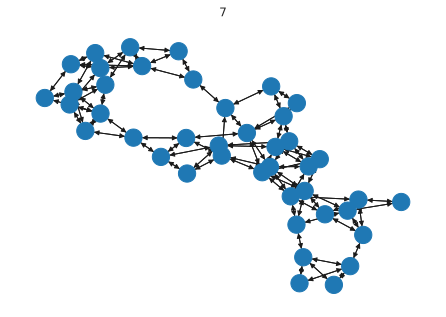

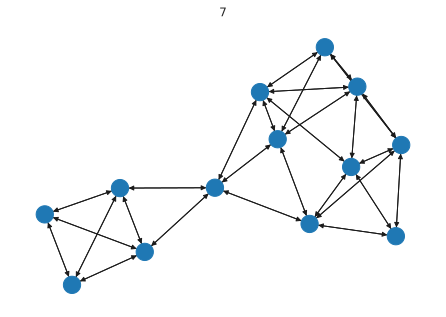

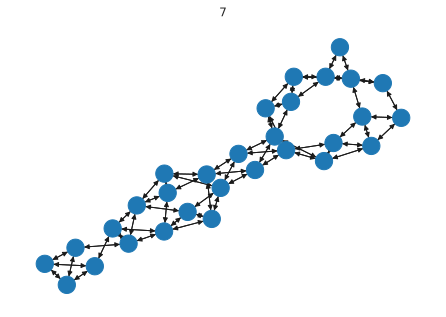

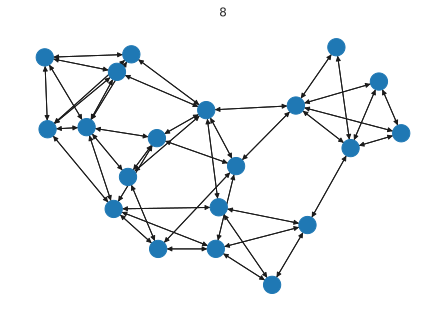

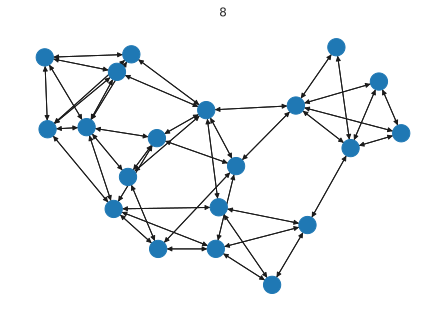

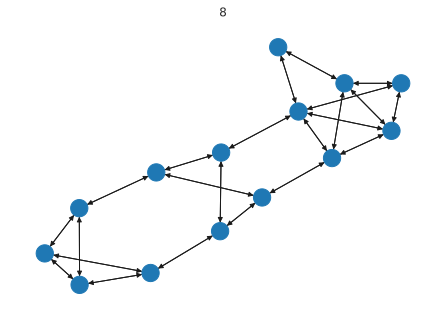

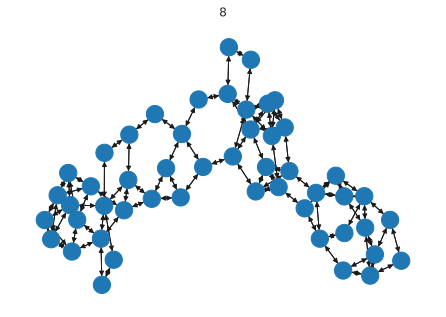

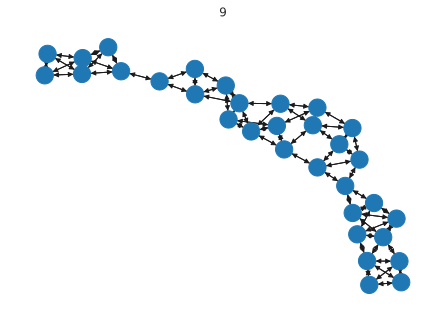

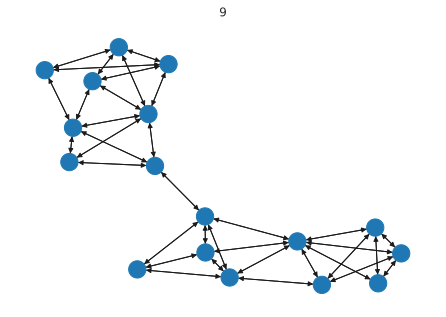

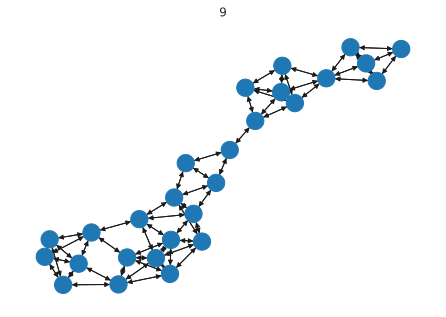

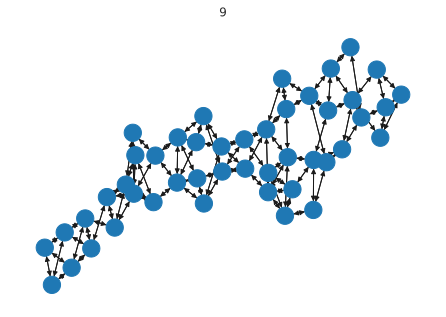

In [134]:
count={k:0 for k in list(set(knn_mean_label))}
for k in list(set(knn_mean_label)):
    for i,data in enumerate(train_dataset):
        if count[k]<=3 and dico_graph_cluster_mean[i]==k:
            G = utils.to_networkx(data,to_undirected=False)
            nx.draw_kamada_kawai(G)
            plt.title(str(k))
            plt.show()
            count[k]+=1

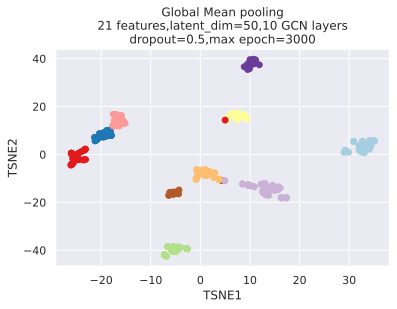

In [144]:
#color represents cluster classification
plt.scatter(t_sne_mean_emb[:,0], t_sne_mean_emb[:,1], c=knn_mean_label,cmap='Paired')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Global Mean pooling\n21 features,latent_dim=50,10 GCN layers\ndropout=0.5,max epoch=3000')
plt.show()

### Global max pooling (warning this a different model so you can not run those cells right after the others)

In [156]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim,n_encode_layer,dropout):
        super(Encoder, self).__init__()
        self.n_encode_layer = n_encode_layer
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.convs.append(pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, n_encode_layer*hidden_dim),
                                  nn.ReLU(), nn.Linear(n_encode_layer*hidden_dim, n_encode_layer*hidden_dim))))
        
        for l in range(n_encode_layer-1,0,-1):
            self.convs.append(pyg_nn.GINConv(nn.Sequential(nn.Linear((l+1)*hidden_dim, l*hidden_dim),
                                  nn.ReLU(), nn.Linear(l*hidden_dim, l*hidden_dim))))
            
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(n_encode_layer*hidden_dim))
        for l in range(n_encode_layer-1,1,-1):
            self.lns.append(nn.LayerNorm(l*hidden_dim))
        
    def forward(self, x, edge_index, batch):
        for i in range(self.n_encode_layer):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.n_encode_layer - 1:
                x = self.lns[i](x)
        zz=pyg_nn.global_max_pool(x, batch)# here you can choose your pooling :different pooling makes a difference
        #zz=pyg_nn.global_mean_pool(x, batch)
        
        list_z=[zz[0]]
        k=0
        for p in range(1,len(batch)):# all of those encoder encodes nodes but the pooling above is at the graph level
            # so here i duplicate the result of the pooling to remake a full graph from it.
            if batch[p]==batch[p-1]:
                list_z.append(zz[k])
            else:
                k+=1
                list_z.append(zz[k])
            
        
        z=torch.vstack(list_z)
        
        
        return x
    
class GraphLevelGNN(pl.LightningModule):
    
    def __init__(self, input_dim, hidden_dim,n_encode_layer,dropout,lr=5e-5):
        super().__init__()
        self.save_hyperparameters()
        
        self.encoder = Encoder(input_dim, hidden_dim,n_encode_layer,dropout)
        self.model = pyg_nn.GAE(self.encoder)
        self.my_learning_rate=lr
        
        
    
    def forward(self, data, mode="train"):
        
        
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch

        xc = self.model.encode(x, edge_index, batch_idx)
        
        loss = self.model.recon_loss(xc, edge_index)
        
        return loss
        
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.my_learning_rate, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer
        
        
    def training_step(self, batch, batch_idx):
        loss= self.forward(batch, mode="train")
        self.log('train_loss', loss)
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        lo = self.forward(batch, mode="val")
        self.log('val_loss', lo)
        
        
    def test_step(self, batch, batch_idx):
        lo = self.forward(batch, mode="test")
        self.log('test_loss', lo)

In [159]:
max_model_path='/home/seb/Documents/Work/Bailer/Python/XML-R/exo_pytorch_geometric/saved_models/GraphLevel_full_duplicate_GIN_AE/lightning_logs/version_2/checkpoints/epoch=2987-step=11951.ckpt'
model_fitted=GraphLevelGNN.load_from_checkpoint(max_model_path,input_dim=21,hidden_dim=50,n_encode_layer=10,dropout=0.5)

In [160]:

        
model_fitted.eval()
embedd_max=[]
target=[]
with torch.no_grad():
    for data in graph_train_loader:
        y=data.y
        batch=data.batch
        edge_index=data.edge_index
        x=data.x
        xx=model_fitted.encoder(x,edge_index,batch)
        list_z=[xx[0]]
        
        for p in range(1,len(batch)):
            if batch[p]!=batch[p-1]:
                list_z.append(xx[p])
        z=torch.vstack(list_z)    
        target+=y.cpu().detach().numpy().tolist()
        embedd_max+=z.cpu().detach().numpy().tolist()

In [161]:
t_sne_max=TSNE()
t_sne_max_emb=t_sne_max.fit_transform(embedd_max)

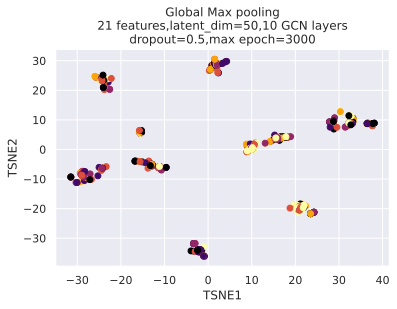

In [162]:
#[21,50,10,0.5] 3000
plt.scatter(t_sne_max_emb[:,0], t_sne_max_emb[:,1], c=target,cmap='inferno')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Global Max pooling\n21 features,latent_dim=50,10 GCN layers\ndropout=0.5,max epoch=3000')
plt.show()

best K : 10


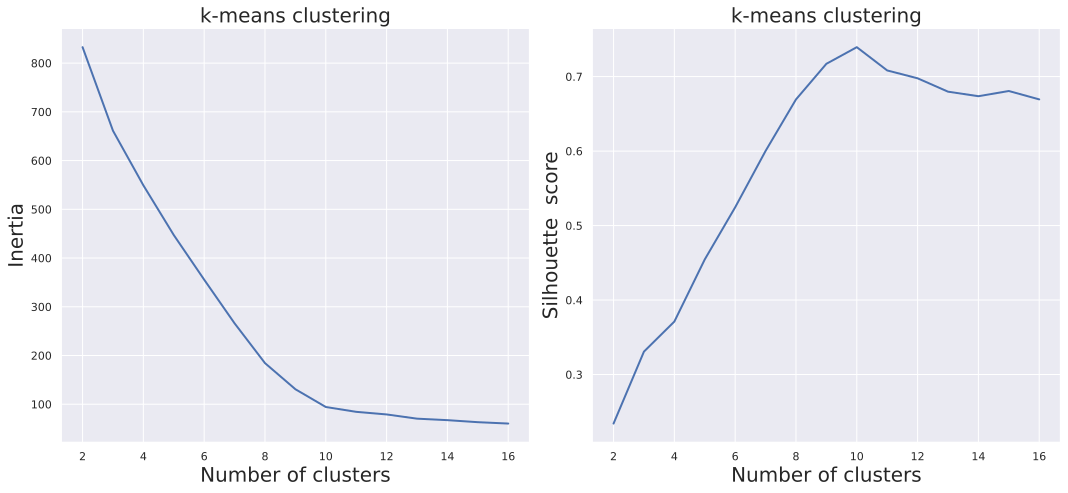

In [163]:
pca = PCA()
X_pca_max = pca.fit_transform(embedd_max)



nr_clusters = np.arange(15)+2
inertias , silhouettes = getSilhouetteProfile( X_pca_max , nr_clusters )

## getting the K with maximum silhouette
bestI = np.argmax( silhouettes )
bestK = nr_clusters[bestI]
print('best K :',bestK)

plt.subplots(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(nr_clusters, inertias, ls="-", lw=2)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Inertia',fontsize=20)
plt.title('k-means clustering',fontsize=20)

plt.subplot(1,2,2)
plt.plot(nr_clusters, silhouettes, ls="-", lw=2)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Silhouette  score',fontsize=20)
plt.title('k-means clustering',fontsize=20)

plt.tight_layout()
plt.show()

In [164]:
kmeans_max = cluster.KMeans(10)
kmeans_max.fit(X_pca_max)

KMeans(n_clusters=10)

In [165]:
knn_max_label=kmeans_max.labels_
dico_graph_cluster_max={}
for i,data in enumerate(train_dataset):
    dico_graph_cluster_max[i]=knn_max_label[i]

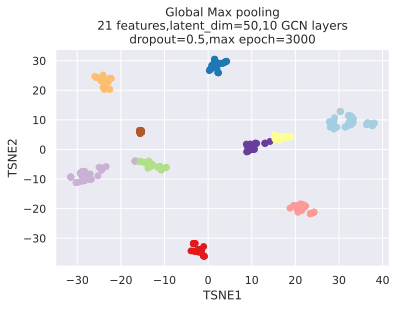

In [166]:
plt.scatter(t_sne_max_emb[:,0], t_sne_max_emb[:,1], c=knn_max_label,cmap='Paired')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Global Max pooling\n21 features,latent_dim=50,10 GCN layers\ndropout=0.5,max epoch=3000')
plt.show()

Here the max pooling clusters doesn't seem to change much .

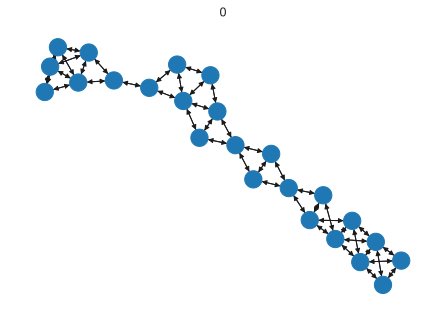

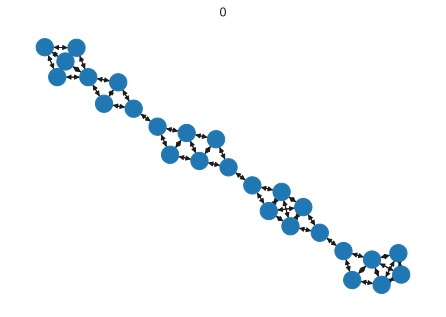

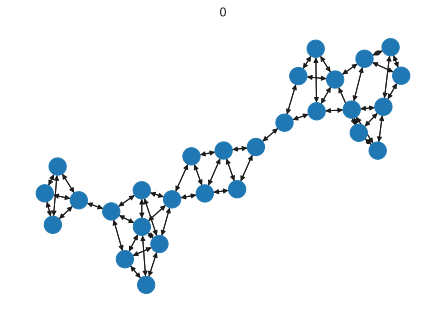

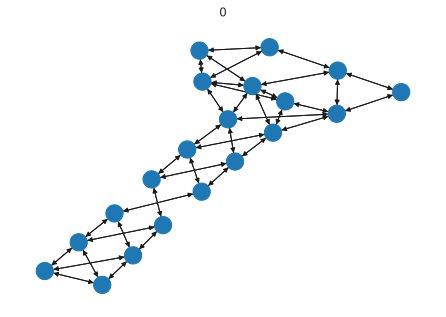

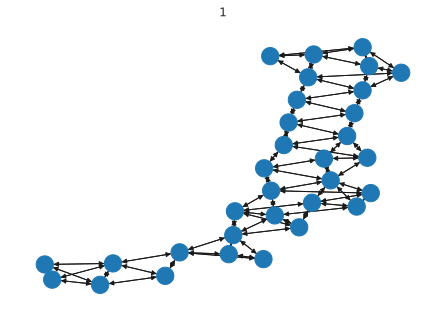

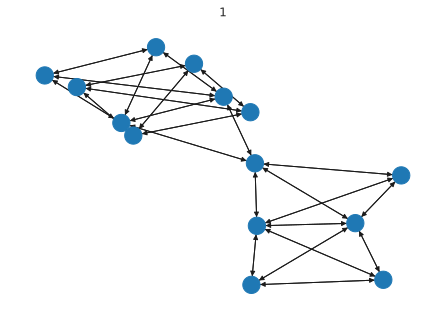

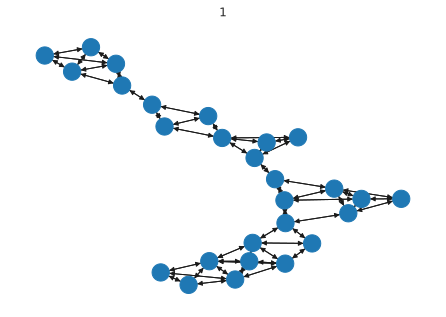

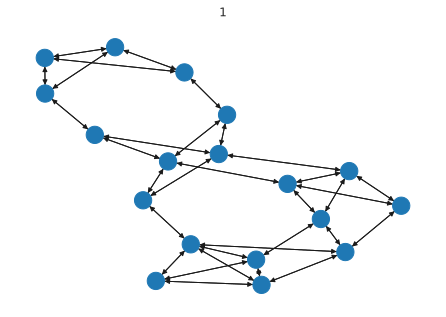

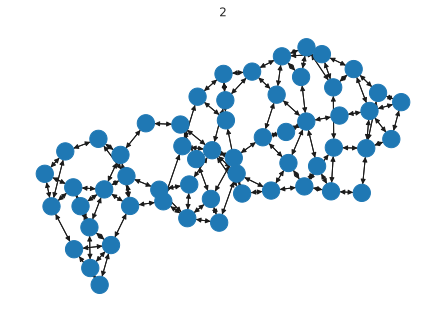

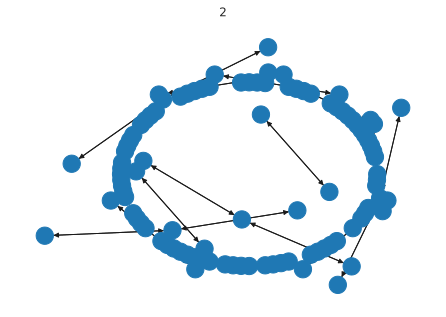

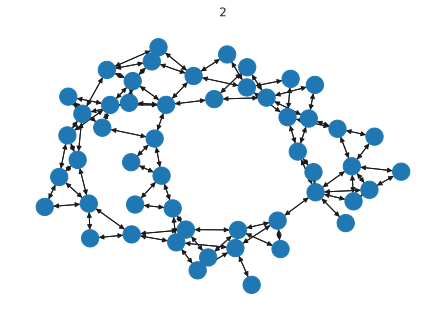

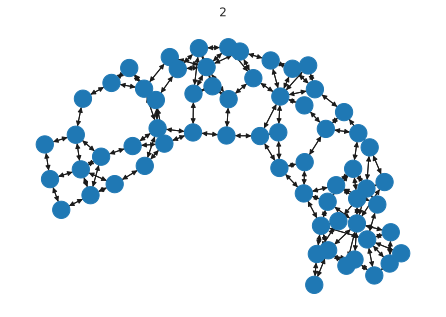

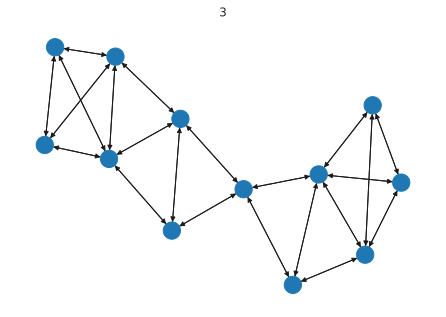

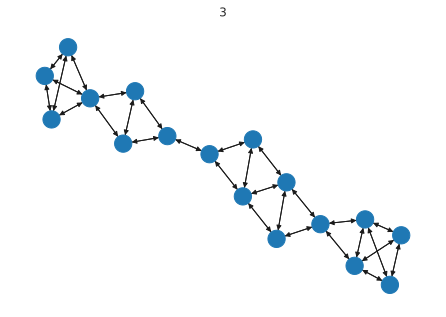

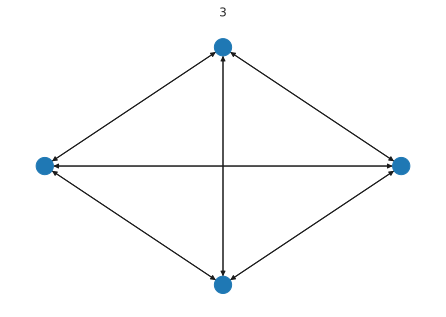

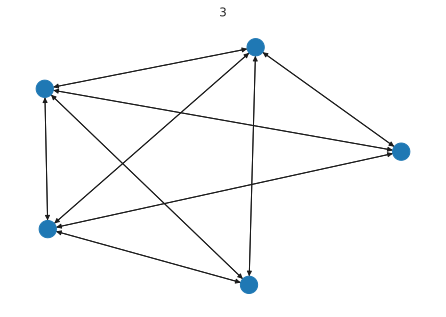

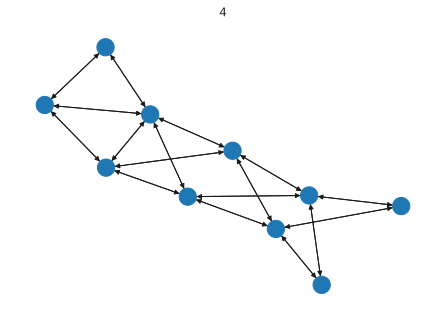

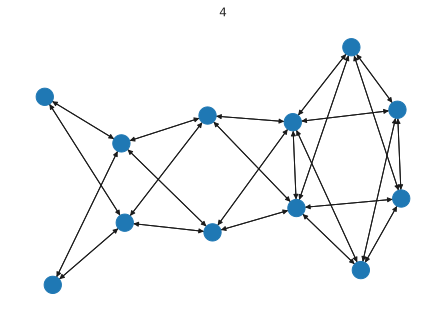

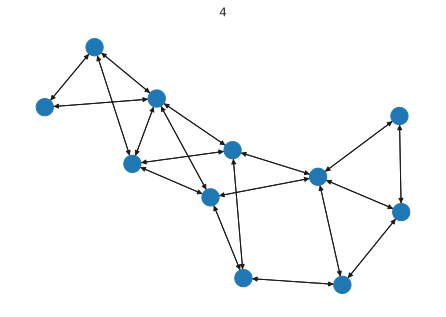

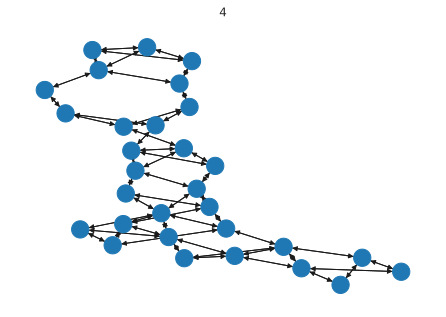

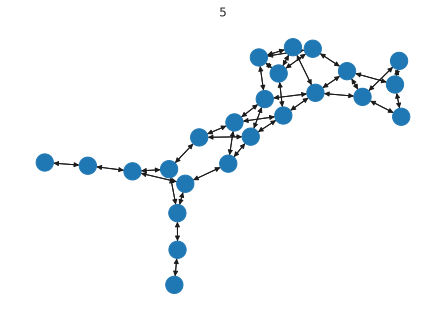

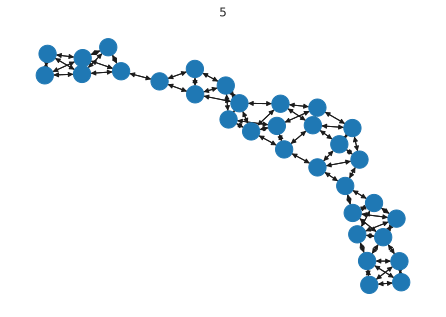

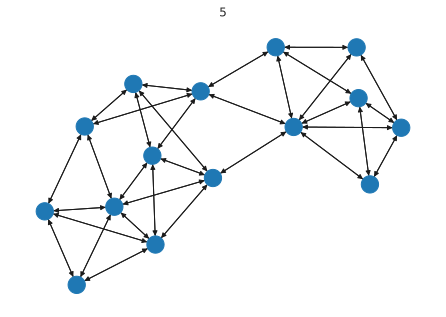

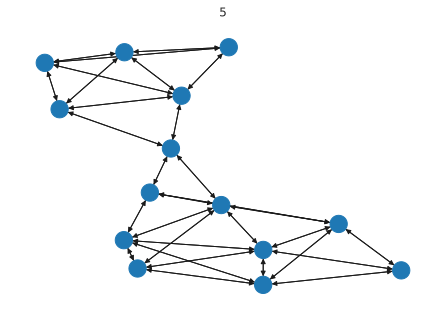

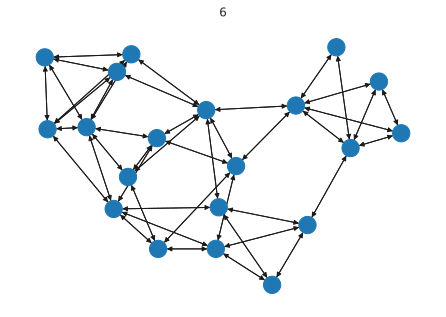

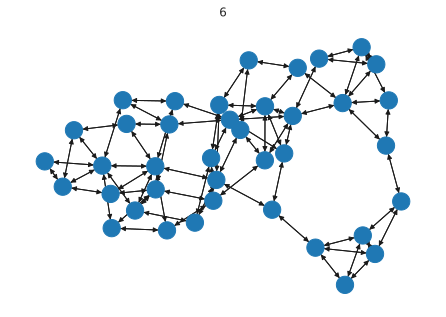

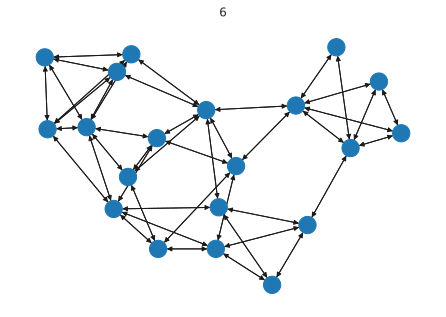

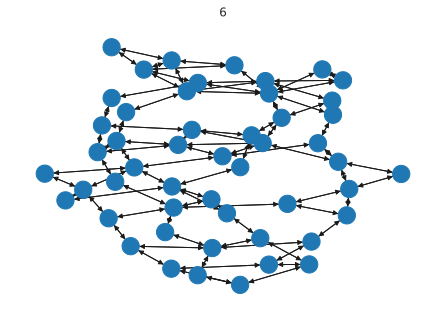

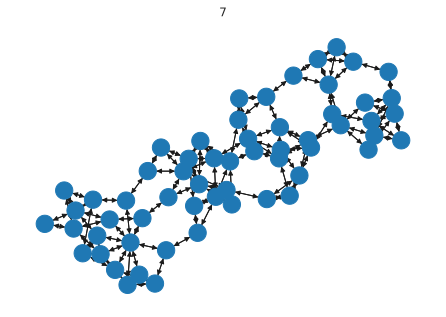

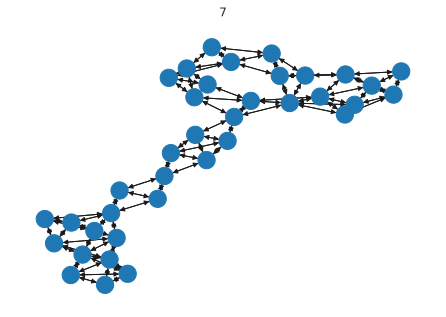

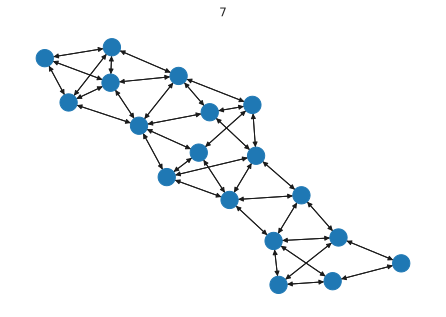

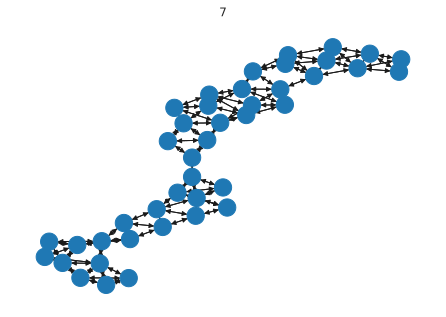

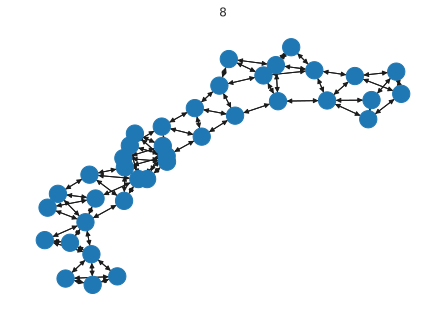

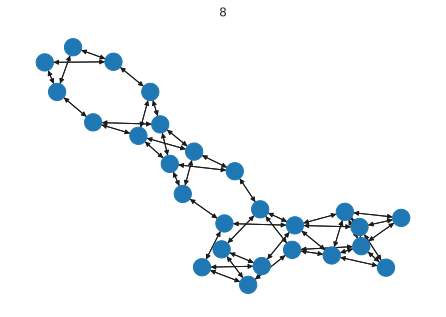

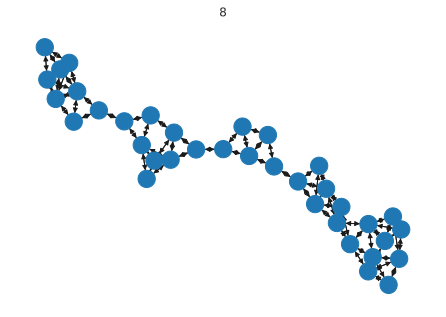

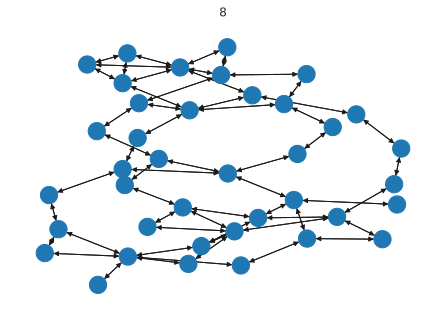

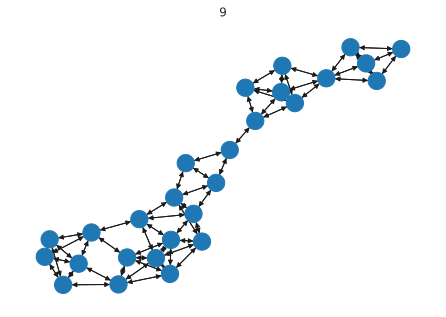

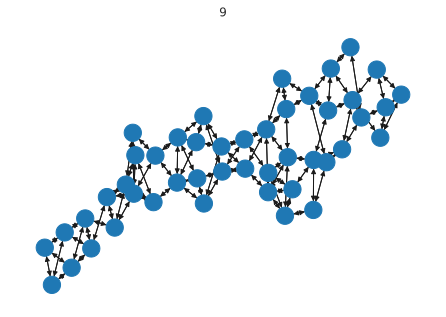

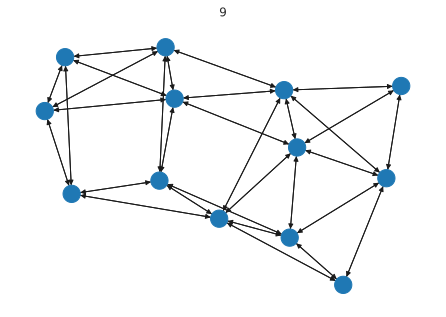

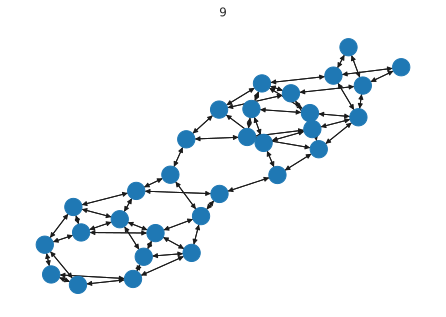

In [167]:
count={k:0 for k in list(set(knn_max_label))}
for k in list(set(knn_max_label)):
    for i,data in enumerate(train_dataset):
        if count[k]<=3 and dico_graph_cluster_max[i]==k:
            G = utils.to_networkx(data,to_undirected=False)
            nx.draw_kamada_kawai(G)
            plt.title(str(k))
            plt.show()
            count[k]+=1